In [8]:
import numpy as np
import matplotlib.pyplot as plt
import nest

nest.ResetKernel()

In [9]:
N = 20  # local synaptic inputs, and set 80% to exc and 20% to inh
              #first I supposed to set 1000,but when N>20, jyputer woule disconnect
N_exc = int(0.8*N)  
N_inh = int(0.2*N)   

w_exc =   80.0   # excitatory synaptic weights
w_inh = -160.0  # inhibitory synaptic weights

nu_loc = 8.0  # spikes/s
nu_ext = 3.0 # synaptic input from the remote excitatory neurons drive the neuron

simtime = 1000



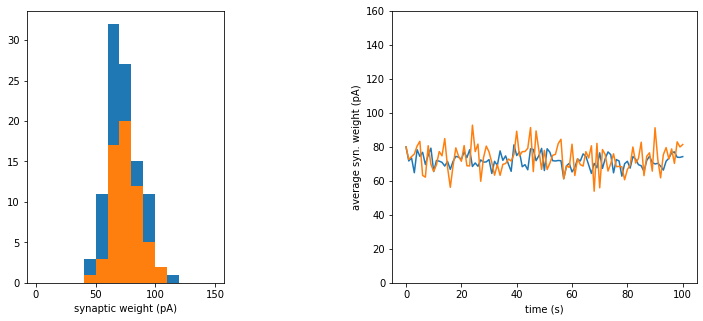

<Figure size 864x360 with 0 Axes>

In [10]:
"""
All local exc synapses STDP and others static.
Use the parrot_neuron to represent the exc inputs and set the first 6 to be the synchronous inputs.
Use the Poisson_generator to generate spikes with the rate nu_loc,
the parrot_neuron receives the spikes sequence and relay them to the integrate-and-fire neuron by STDP synapses.
Show the difference spiking inputs(synchronous/others)
"""

n_syn  = 6  #synchronously spiking inputs
nu_syn =  3.0  # rate of  spikes

neuron = nest.Create('izhikevich')
#neuron = nest.Create('iaf_psc_alpha')

# excitatory inputs
p_exc = nest.Create('poisson_generator', 1, {'rate': nu_loc})
inputs = nest.Create('parrot_neuron', N_exc)

# the first n syn exc inputs
p_exc_syn = nest.Create('poisson_generator', 1, {'rate': nu_syn})
parrot_syn = nest.Create('parrot_neuron') 
p_exc_a = nest.Create('poisson_generator', 1, {'rate': nu_loc-nu_syn}) 

# inh & exc inputs
p_inh = nest.Create('poisson_generator', 1, {'rate': N_inh*nu_loc})
p_ext = nest.Create('poisson_generator', 1, {'rate': N_exc*nu_ext})

# record spikes from the neuron
sd = nest.Create('spike_detector', 1, {'to_file': False, 'to_memory': True})

# STDP params
nest.SetStatus(neuron,{'tau_minus': 20.0})
nest.SetDefaults('stdp_synapse', {'tau_plus': 20.0,
                                  'mu_plus':   1.0,
                                  'mu_minus':  1.0,
                                  'alpha':     1.0,
                                  'lambda':    0.1,
                                  'Wmax':      2.0*w_exc})

nest.Connect(p_exc, inputs[n_syn:])
nest.Connect(inputs, neuron, syn_spec={'model': 'stdp_synapse', 'weight': w_exc})

nest.Connect(p_exc_syn, parrot_syn)
nest.Connect(parrot_syn, inputs[:n_syn])
nest.Connect(p_exc_a, inputs[:n_syn])

nest.Connect(p_inh, neuron, syn_spec={'weight': w_inh})
nest.Connect(p_ext, neuron, syn_spec={'weight': w_exc})

nest.Connect(neuron, sd)

stdp_conn = nest.GetConnections(inputs[n_syn:])
stdp_conn_syn = nest.GetConnections(inputs[:n_syn])

ws_all = np.array(nest.GetStatus(stdp_conn,'weight'))
ws_all_s = np.array(nest.GetStatus(stdp_conn_syn,'weight'))
ws_means = np.mean(ws_all)
ws_means_s = np.mean(ws_all_s)
 
for i in range(100):
    nest.Simulate(simtime)
    ws = nest.GetStatus(stdp_conn,'weight')
    ws_all = np.append(ws_all, ws)
    ws_means = np.append(ws_means, np.mean(ws))
    ws = nest.GetStatus(stdp_conn_syn,'weight')
    ws_all_s = np.append(ws_all_s, ws)
    ws_means_s = np.append(ws_means_s, np.mean(ws))

fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(131)
ax1.hist(ws_all[-10*(N_exc-n_syn):],bins=range(0,int(2*w_exc),10))
ax1.hist(ws_all_s[-10*n_syn:],bins=range(0,int(2*w_exc),10))
ax1.set_xlabel('synaptic weight (pA)')


#average synaptic weight over time
ax2 = fig.add_subplot(122)
ax2.plot(ws_means)
ax2.plot(ws_means_s)
ax2.set_ylim([0,2.0*w_exc])
ax2.set_xlabel('time (s)')
ax2.set_ylabel('average syn. weight (pA)')

fig = plt.figure(figsize=(12,5))
